In [28]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

In [8]:
df = pd.read_csv("face_images/selfie_id.csv")

In [9]:
df.shape

(435, 6)

In [10]:
df.head()

,SetId,UserRace,Age,Name,FName,URL
0,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,ID_1.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...
1,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,ID_2.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...
2,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_1.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...
3,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_10.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...
4,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_11.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...


In [16]:
# Define the base directory where images are stored
base_dir = "face_images/Selfies ID Images dataset"

# Define the new directory for all images
destination_folder = "all_faces"
os.makedirs(destination_folder, exist_ok=True)

# Function to move images and update the path
def move_images(row):
    old_path = os.path.join(base_dir, row["URL"])
    
    # Create a new filename to ensure uniqueness
    new_filename = f"{row['SetId']}_{row['FName']}"
    new_path = os.path.join(destination_folder, new_filename)

    # Copy the file if it exists
    if os.path.exists(old_path):
        shutil.copy(old_path, new_path)
        return new_path  # Return the new relative path
    else:
        print(f"File not found: {old_path}")
        return None  # Mark missing files

# Apply function to update the DataFrame
df["NewPath"] = df.apply(move_images, axis=1)


File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/ID_1.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/ID_2.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_1.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_10.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_11.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_12.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_13.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af892e1735844b198f7269_age_28_name_Luis/Selfie_2.jpg
File not found: face_images/Selfies 

In [13]:
df.head()

File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/ID_1.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/ID_2.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_1.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_10.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_11.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_12.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_13.jpg
File not found: face_images/Selfies ID Images dataset/0001cc1e1e--61af8513667cba1b47349869_age_25_name_Weslley/Selfie_2.jpg
File not fou

In [23]:
df.sample(10)

,SetId,UserRace,Age,Name,FName,URL,NewPath
275,0001ca9b9a--61abcfbb45612c79df4dba1f,Caucasian,22,Anna,Selfie_12.jpg,0001ca9b9a--61abcfbb45612c79df4dba1f_age_22_na...,all_faces/0001ca9b9a--61abcfbb45612c79df4dba1f...
332,0001ca9b9a--61acdab83e0f222c5afd75a2,Caucasian,51,GuС‚РҐР°+Рєlten CС‚РҐР°TВ¦ayС‚Р¤РђС‚Р¦РўrcС‚Р¤...,Selfie_1.jpg,0001ca9b9a--61acdab83e0f222c5afd75a2_age_51_na...,None
72,0001cc1e1e--61af8a351735844b198f7ade,Hispanic,26,Fernanda,Selfie_7.jpg,0001cc1e1e--61af8a351735844b198f7ade_age_26_na...,all_faces/0001cc1e1e--61af8a351735844b198f7ade...
89,0001cc1e1e--61af8aa9d46ff461a71462cc,Hispanic,31,Daiane,Selfie_9.jpg,0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_na...,all_faces/0001cc1e1e--61af8aa9d46ff461a71462cc...
46,0001cc1e1e--61af89eea5a19325b68a2801,Hispanic,28,Rayanne,ID_2.jpg,0001cc1e1e--61af89eea5a19325b68a2801_age_28_na...,all_faces/0001cc1e1e--61af89eea5a19325b68a2801...
107,0001cc1e1e--61af8bd7667cba1b473506bd,Hispanic,34,RoС‚РҐР°+Р№mulo,Selfie_1.jpg,0001cc1e1e--61af8bd7667cba1b473506bd_age_34_na...,None
382,0001ca9b9a--61ad582184c9021db9ea19df,Caucasian,45,Massimiliano,Selfie_2.jpg,0001ca9b9a--61ad582184c9021db9ea19df_age_45_na...,None
103,0001cc1e1e--61af8b9119bf98074e184806,Hispanic,32,Alejandra,Selfie_8.jpg,0001cc1e1e--61af8b9119bf98074e184806_age_32_na...,all_faces/0001cc1e1e--61af8b9119bf98074e184806...
273,0001ca9b9a--61abcfbb45612c79df4dba1f,Caucasian,22,Anna,Selfie_10.jpg,0001ca9b9a--61abcfbb45612c79df4dba1f_age_22_na...,all_faces/0001ca9b9a--61abcfbb45612c79df4dba1f...
86,0001cc1e1e--61af8aa9d46ff461a71462cc,Hispanic,31,Daiane,Selfie_6.jpg,0001cc1e1e--61af8aa9d46ff461a71462cc_age_31_na...,all_faces/0001cc1e1e--61af8aa9d46ff461a71462cc...


In [20]:
df.tail()

,SetId,UserRace,Age,Name,FName,URL,NewPath
430,0001ca9b9a--61af51c056ee9447b653e097,Caucasian,18,Valeriia,Selfie_5.jpg,0001ca9b9a--61af51c056ee9447b653e097_age_18_na...,None
431,0001ca9b9a--61af51c056ee9447b653e097,Caucasian,18,Valeriia,Selfie_6.jpg,0001ca9b9a--61af51c056ee9447b653e097_age_18_na...,None
432,0001ca9b9a--61af51c056ee9447b653e097,Caucasian,18,Valeriia,Selfie_7.jpg,0001ca9b9a--61af51c056ee9447b653e097_age_18_na...,None
433,0001ca9b9a--61af51c056ee9447b653e097,Caucasian,18,Valeriia,Selfie_8.jpg,0001ca9b9a--61af51c056ee9447b653e097_age_18_na...,None
434,0001ca9b9a--61af51c056ee9447b653e097,Caucasian,18,Valeriia,Selfie_9.jpg,0001ca9b9a--61af51c056ee9447b653e097_age_18_na...,None


In [24]:
df = df.dropna(subset=["NewPath"])


In [25]:
df.shape

(315, 7)

In [26]:
df['Name'].value_counts()

Name
Weslley       15
Klara         15
Mark          15
Alessandro    15
Vitalijs      15
Mykhailo      15
Kateryna      15
Anna          15
Ewa           15
Diego         15
Miia          15
Juliana       15
Paolo         15
Clarissa      15
Gabriel       15
Bruno         15
Alejandra     15
Daiane        15
Fernanda      15
Rayanne       15
Kasia         15
Name: count, dtype: int64

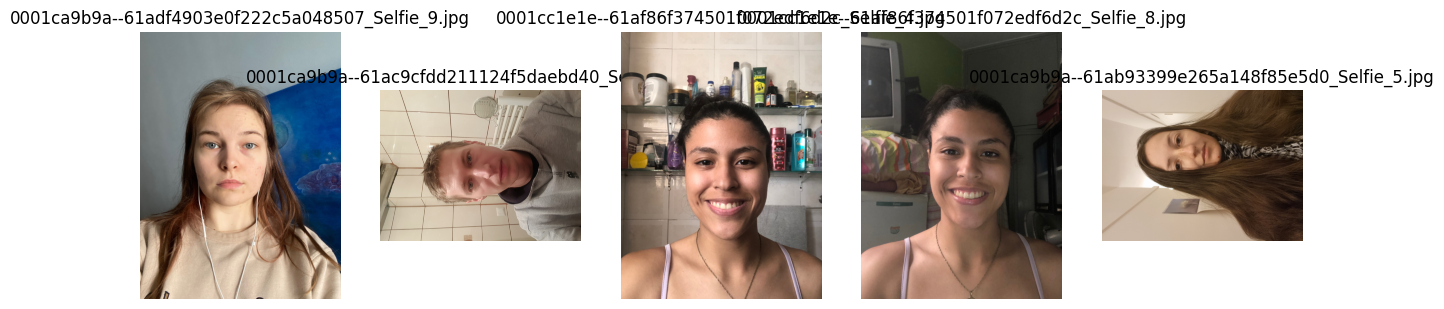

In [30]:
sample_paths = df["NewPath"].sample(5).tolist()  # Pick 5 random images
# Display the images
fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 5))

for ax, img_path in zip(axes, sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_path.split("/")[-1])  # Show filename

plt.show()

In [44]:
# Using Facenet to Embed Images into Vectors
from keras_facenet import FaceNet

# Load the pre-trained FaceNet model
embedder = FaceNet()

In [45]:
# Extracting the Face Embeddings
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to extract embeddings for all images
def get_embeddings(image_paths):
    embeddings = []
    for path in image_paths:
        img = load_img(path, target_size=(160, 160))  # Resize to 160x160
        img = img_to_array(img) / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Expand dimensions
        embedding = embedder.embeddings(img)  # Get FaceNet embedding
        embeddings.append(embedding[0])
    return np.array(embeddings)

# Apply to dataset
X = get_embeddings(df["NewPath"].tolist())  # Convert all images to embeddings
y = df["Name"].values  # Labels